In [1]:
import swirl
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.tri as tri

from utils_mitgcm import open_mitgcm_ds_from_config

import eddytools_core as et

In [2]:
model = 'geneva_200m'
str_start_time = "2023-07-01T12:00:00.000000000"
str_end_time = "2023-07-17T00:00:00.000000000"

params_file = 'swirl_03'

# Open MITgcm results

In [3]:
mitgcm_config, ds_to_plot = open_mitgcm_ds_from_config('../config.json', model)

# Preprocess MITgcm inputs

In [4]:
data_aligned = et.detection_nencioli.preprocess_inputs(str_start_time, str_end_time, ds_to_plot, depth_index=0)

# Run SWIRL

In [5]:
def run_swirl(data_snapshot):
    u_plot = data_snapshot['UVEL'].values
    v_plot = data_snapshot['VVEL'].values
    u_plot = np.where(np.isnan(u_plot), 0, u_plot).T
    v_plot = np.where(np.isnan(v_plot), 0, v_plot).T
    dx = data_snapshot.dxC.values[0][0]
    dy = data_snapshot.dyC.values[0][0]
    
    vortices = swirl.Identification(v=[u_plot, v_plot],
                                grid_dx=[dx,dy],
                                param_file=f'../{params_file}.param',
                                verbose=True)
    vortices.run()
    
    return vortices

In [6]:
eddies = {}
for t_index in range(len(data_aligned.time.values)):
    snapshot = data_aligned.isel(time=t_index)
    snapshot_vortices = run_swirl(snapshot)
    eddies[t_index] = snapshot_vortices

---------------------------------------------------------
---                                                   ---
---    _/_/_/  _/          _/  _/   _/_/_/    _/      ---
---  _/         _/        _/   _/   _/    _/  _/      ---
---    _/_/      _/      _/    _/   _/_/_/    _/      ---
---        _/     _/ _/ _/     _/   _/  _/    _/      ---
---  _/_/_/        _/  _/      _/   _/   _/   _/_/_/  ---
---                                                   ---
---------------------------------------------------------
---------------------------------------------------------
---                                                   ---
---               (c) IRSOL, 11.04.2022               ---
---                                                   ---
--- Author:      José Roberto Canivete Cuissa         ---
--- Email:       jcanivete@ics.uzh.ch                 ---
---------------------------------------------------------
---
--- Parameters:
---------------
---    grid_dx          : 200.0, 200

# Save results

## Reformat results into xarray

In [7]:
def interpolate_value_from_index(coord_array_1d, index):
    return np.interp(index, np.arange(len(coord_array_1d)), coord_array_1d)

In [8]:
eddy_list = []
id=0

for t_index in eddies:
    for eddy in eddies[t_index]:
        eddy_list.append({
            'eddy_id': id,
            'time': data_aligned.time.values[t_index],
            'x_center': interpolate_value_from_index(data_aligned.lon.values, eddy.center[0]),
            'y_center': interpolate_value_from_index(data_aligned.lat.values, eddy.center[1]),
            'radius': eddy.radius,
            'x_extent': [interpolate_value_from_index(data_aligned.lon.values, i_eddy) for i_eddy in eddy.vortex_cells[0]],
            'y_extent': [interpolate_value_from_index(data_aligned.lat.values, j_eddy) for j_eddy in eddy.vortex_cells[1]],
            'type': -1 * eddy.orientation,
        })
        id +=1


# Build a xarray
max_extent_len = max(len(e['x_extent']) for e in eddy_list)
x_extent_array = np.full((len(eddy_list), max_extent_len), np.nan)
y_extent_array = np.full((len(eddy_list), max_extent_len), np.nan)
for i, e in enumerate(eddy_list):
    x_extent_array[i, :len(e['x_extent'])] = e['x_extent']
    y_extent_array[i, :len(e['y_extent'])] = e['y_extent']

eddy_ds = xr.Dataset(
    data_vars={
        'x_center': ('eddy_id', np.array([e['x_center'] for e in eddy_list])),
        'y_center': ('eddy_id', np.array([e['y_center'] for e in eddy_list])),
        'radius': ('eddy_id', np.array([e['radius'] for e in eddy_list])),
        'x_extent': (('eddy_id', 'extent_index'), x_extent_array),
        'y_extent': (('eddy_id', 'extent_index'), y_extent_array),
        'type': ('eddy_id', np.array([e['type'] for e in eddy_list])),
    },
    coords={
        'eddy_id': np.array([e['eddy_id'] for e in eddy_list]),
        'time': ('eddy_id', np.array([e['time'] for e in eddy_list])),
    }
)

# Plot

In [9]:
def plot_map_eddies(snapshot_vel, snapshot_eddies, title, stream_density = 6):
    x_plot, y_plot = np.meshgrid(snapshot_vel['lon'], snapshot_vel['lat'])
    u_plot = snapshot_vel['UVEL'].values
    v_plot = snapshot_vel['VVEL'].values
    
    plt.close('all')
    fig = plt.figure(figsize=(15, 5))

    # Plot background scalar field (e.g., UVEL)
    snapshot_vel["UVEL"].plot()

    # Plot streamlines
    plt.streamplot(x_plot, y_plot, u_plot, v_plot, 
                   density=stream_density, color='black', linewidth=0.5, 
                   arrowsize=0.7, arrowstyle='->')

    # Overlay eddies
    for id in snapshot_eddies.eddy_id:
        lon_eddy = np.array(snapshot_eddies.sel(eddy_id=id)['x_extent'].values)
        lat_eddy = np.array(snapshot_eddies.sel(eddy_id=id)['y_extent'].values)
        lon_eddy = lon_eddy[~np.isnan(lon_eddy)]
        lat_eddy = lat_eddy[~np.isnan(lat_eddy)]

        try:
            triang = tri.Triangulation(lon_eddy, lat_eddy)
            plt.tripcolor(triang, facecolors=np.full(len(triang.triangles), 1.0), 
                          cmap=plt.cm.Greens, vmin=0, vmax=4, alpha=1)
        except Exception as e:
            plt.scatter(lon_eddy, lat_eddy, c='lightgreen')
        # Eddy center
        color = ['gold' if snapshot_eddies.sel(eddy_id=id).type.values == -1 else 'green']
        plt.scatter(snapshot_eddies.sel(eddy_id=id)['x_center'], snapshot_eddies.sel(eddy_id=id)['y_center'], c=color, zorder=10)

    plt.text(0.02, 0.98, f'Z={round(float(snapshot_vel.Depth.values),2)}m', transform=plt.gca().transAxes, ha='left', va='top')
    plt.title(title)
    
    return fig

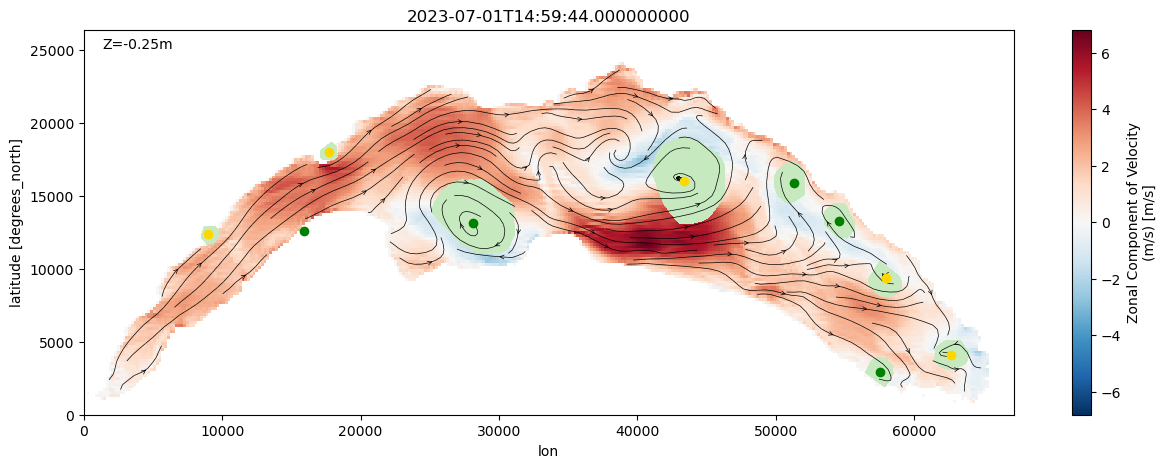

In [10]:
t_index = 3
time=data_aligned.isel(time=t_index).time.values
fig=plot_map_eddies(data_aligned.isel(time=t_index), eddy_ds.sel(eddy_id=eddy_ds.time == time), str(time), stream_density = 2)

In [11]:
def plot_map_swirl(snapshot, vortices, title, stream_density):
    # rortex
    plt.close('all')
    fig=plt.figure(figsize=(15,5))
    plt.imshow(vortices.rortex[0].T, cmap='PiYG', vmin=-0.01, vmax=0.01)
    plt.gca().invert_yaxis()
    cbar=plt.colorbar()
    cbar.set_label('Rortex R')
    
    # streamlines
    nx_grid = vortices.v.x.shape[0]
    ny_grid = vortices.v.x.shape[1]
    xrange = np.arange(0, nx_grid)
    yrange = np.arange(0, ny_grid)
    xgrid, ygrid = np.meshgrid(xrange, yrange)
    u_plot = snapshot['UVEL'].values
    v_plot = snapshot['VVEL'].values
    plt.streamplot(xgrid, ygrid, u_plot, v_plot, 
                   density=stream_density, color='black', linewidth=0.5, 
                   arrowsize=0.7, arrowstyle='->')
    
    # Extent
    for vortex in vortices:
        plt.scatter(vortex.vortex_cells[0], vortex.vortex_cells[1], s=0.2, c='blue')
        plt.scatter(vortex.center[0], vortex.center[1],marker='*', s=50, c='red', zorder=10)
    
    plt.text(0.02, 0.98, f'Z={round(float(snapshot.Depth.values),2)}m', transform=plt.gca().transAxes, ha='left', va='top')
    plt.title(title)
    
    return fig

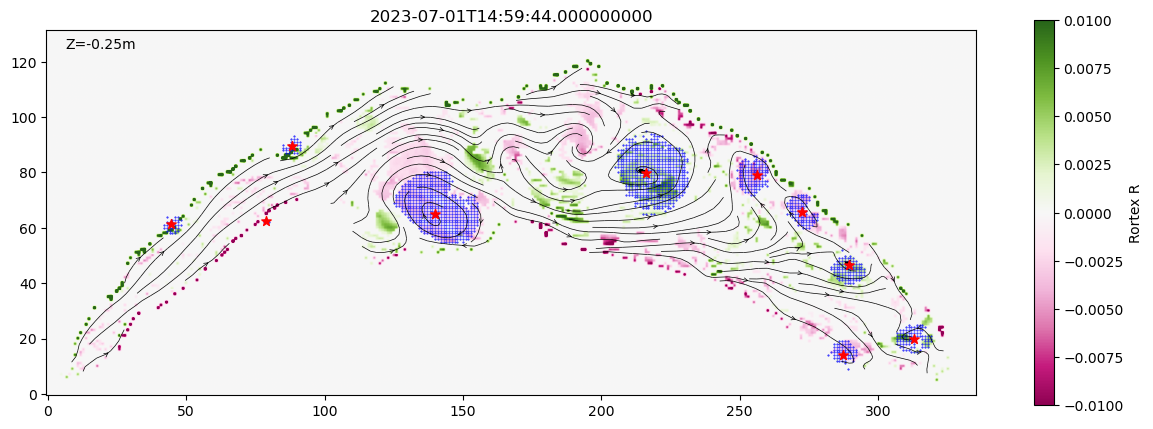

In [12]:
t_index = 3
time=data_aligned.isel(time=t_index).time.values
test=plot_map_swirl(data_aligned.isel(time=t_index), eddies[t_index], str(time), stream_density = 2)

# Save results

In [13]:
eddy_ds.to_netcdf(rf'../99-Outputs/swirl/{params_file}_200m.nc')

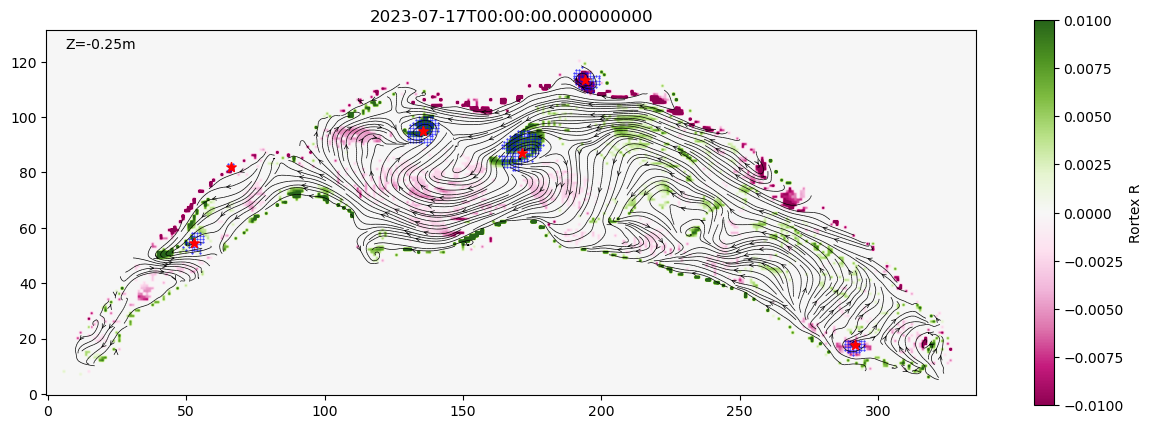

In [14]:
for t_plot in range(0,len(eddies)):
    time=data_aligned.isel(time=t_plot).time.values
    fig = plot_map_swirl(data_aligned.isel(time=t_plot), 
                          eddies[t_plot], 
                          str(time),
                          6 # streamplot density (default=6)
                         )
    plt.savefig(rf'../99-Outputs/swirl/{params_file}_t{t_plot}.png')